A# --- 0. Cabeçalho de Negócios (Transformar esta célula para Markdown no notebook) ---
"""
# Análise Exploratória de Dados (EDA) - Projeto Datathon Decision

## Entendendo o Sucesso no Recrutamento e Seleção

Este notebook apresenta a Análise Exploratória de Dados (EDA) para o projeto Datathon, focado em otimizar os processos de recrutamento e seleção da empresa Decision. Nosso objetivo principal é transformar os dados brutos de vagas, prospecções e candidatos em informações acionáveis que nos permitam **identificar padrões de "match" bem-sucedidos** e, futuramente, construir um modelo preditivo.

### Qual o Propósito desta Análise?

Através desta exploração, buscamos:

1.  **Compreender a Estrutura dos Dados:** Como as informações sobre vagas (`vagas.json`), prospecções (`prospects.json`) e candidatos (`applicants.json`) se relacionam e podem ser combinadas.
2.  **Identificar Candidatos de Sucesso:** Definir e quantificar o que significa um "match de sucesso" (candidatos contratados) com base nos dados históricos.
3.  **Descobrir Tendências e Padrões:** Analisar características comuns entre os candidatos contratados e as vagas preenchidas com sucesso. Quais são os níveis de experiência, habilidades e formações mais prevalentes?
4.  **Avaliar a Qualidade dos Dados:** Identificar lacunas, inconsistências e a necessidade de tratamento (limpeza, padronização) para que os dados possam ser utilizados em modelos de Machine Learning.
5.  **Informar a Próxima Etapa:** As descobertas aqui guiarão a criação de novas "features" (características) a partir dos dados existentes, essenciais para o treinamento de um algoritmo de predição.

### Como esta Análise Contribui para a Decision?

Esta EDA é o alicerce para o desenvolvimento de uma inteligência artificial que poderá:

* **Otimizar o Tempo dos Hunters:** Fornecendo insights rápidos sobre o perfil ideal de candidato para cada vaga.
* **Melhorar a Precisão do "Match":** Baseando as recomendações em dados concretos de sucesso passado, não apenas em intuição.
* **Aumentar o Engajamento e a Retenção:** Ao ajudar a identificar candidatos que não apenas atendem aos requisitos técnicos, mas que também se alinham culturalmente e demonstram alto engajamento.

Ao final desta análise, teremos uma base sólida de conhecimento sobre nossos dados e um caminho claro para construir uma solução que torne o processo de recrutamento da Decision mais ágil, eficaz e estratégico.
"""

In [11]:
# --- 1. Importando as bibliotecas ---
import pandas as pd
import json
import os
import matplotlib.pyplot as plt
import seaborn as sns

# Configurações para melhor visualização em notebooks Jupyter
pd.set_option('display.max_columns', None) # Mostrar todas as colunas
pd.set_option('display.width', 1000)      # Largura da exibição para evitar quebras de linha
pd.set_option('display.max_rows', 100)    # Mostrar até 100 linhas

In [12]:
# --- 2. Carregamento dos Dados ---
print("--- 2. Carregando os Dados ---")

# Define o caminho base para a pasta 'data'
# Certifique-se que o notebook está em 'notebooks/' e os dados em 'data/'
data_path = '../data/'

# Carrega os arquivos JSON
try:
    with open(os.path.join(data_path, 'vagas.json'), 'r', encoding='utf-8') as f:
        jobs_data = json.load(f)

    with open(os.path.join(data_path, 'prospects.json'), 'r', encoding='utf-8') as f:
        prospects_data = json.load(f)

    with open(os.path.join(data_path, 'applicants.json'), 'r', encoding='utf-8') as f:
        applicants_data = json.load(f)

    print("Arquivos JSON carregados com sucesso.")

except FileNotFoundError as e:
    print(f"Erro: Arquivo não encontrado. Verifique o caminho e o nome do arquivo. Erro: {e}")
    print(f"Caminho esperado: {os.path.abspath(data_path)}")
    # Se os arquivos não forem encontrados, verifique se estão em C:\Users\vanessa.anjos_a3data\Documents\DATATHON\data\
    # E se o notebook está em C:\Users\vanessa.anjos_a3data\Documents\DATATHON\notebooks\

--- 2. Carregando os Dados ---
Arquivos JSON carregados com sucesso.


In [13]:
# --- 3. Convertendo JSONs para DataFrames Pandas ---

# jobs_data: Já é um dicionário onde as chaves são os IDs das vagas.
# Criaremos um DataFrame diretamente a partir dos valores.
jobs_df = pd.DataFrame.from_dict(jobs_data, orient='index')
jobs_df.index.name = 'job_id'
print("\n--- jobs_df ---")
print(f"Shape: {jobs_df.shape}")
print(jobs_df.head())
print(jobs_df.info())


# prospects_data: É um dicionário onde as chaves são os IDs das vagas, e os valores contêm uma lista de prospects.
# Precisamos "achatar" essa estrutura.
prospects_records = []
for job_id, job_info in prospects_data.items():
    if 'prospects' in job_info and isinstance(job_info['prospects'], list):
        for prospect in job_info['prospects']:
            # Adiciona o job_id a cada prospect para facilitar a junção
            prospect_record = {'job_id': job_id}
            prospect_record.update(job_info) # Adiciona titulo e modalidade da vaga
            prospect_record.pop('prospects', None) # Remove a lista de prospects para evitar duplicação
            prospect_record.update(prospect) # Adiciona os detalhes do prospect
            prospects_records.append(prospect_record)
prospects_df = pd.DataFrame(prospects_records)
prospects_df['job_id'] = prospects_df['job_id'].astype(str) # Garante que job_id seja string para join
prospects_df['codigo'] = prospects_df['codigo'].astype(str) # Garante que codigo do candidato seja string para join

print("\n--- prospects_df ---")
print(f"Shape: {prospects_df.shape}")
print(prospects_df.head())
print(prospects_df.info())


# applicants_data: Similar ao jobs_data, as chaves são os IDs dos candidatos.
applicants_df = pd.DataFrame.from_dict(applicants_data, orient='index')
applicants_df.index.name = 'applicant_id'
applicants_df.reset_index(inplace=True) # Move applicant_id para uma coluna regular
applicants_df['applicant_id'] = applicants_df['applicant_id'].astype(str) # Garante que applicant_id seja string para join

print("\n--- applicants_df ---")
print(f"Shape: {applicants_df.shape}")
print(applicants_df.head())
print(applicants_df.info())


--- jobs_df ---
Shape: (14081, 3)
                                      informacoes_basicas                                        perfil_vaga                                         beneficios
job_id                                                                                                                                                         
5185    {'data_requicisao': '04-05-2021', 'limite_espe...  {'pais': 'Brasil', 'estado': 'São Paulo', 'cid...  {'valor_venda': '-', 'valor_compra_1': 'R$', '...
5184    {'data_requicisao': '04-05-2021', 'limite_espe...  {'pais': 'Brasil', 'estado': 'São Paulo', 'cid...  {'valor_venda': '-', 'valor_compra_1': 'R$', '...
5183    {'data_requicisao': '04-05-2021', 'limite_espe...  {'pais': 'Brasil', 'estado': 'São Paulo', 'cid...  {'valor_venda': '-', 'valor_compra_1': 'R$', '...
5182    {'data_requicisao': '04-05-2021', 'limite_espe...  {'pais': 'Brasil', 'estado': 'São Paulo', 'cid...  {'valor_venda': '- p/ mês (168h)', 'valor_comp...
5181 

In [17]:
# --- 4. Normalização (Achatar JSONs Aninhados para Facilitação) ---

# Função auxiliar para achatar dicionários aninhados em colunas de nível superior
def flatten_json_column(df_to_flatten, column_name_to_flatten):
    # Usa json_normalize para converter o dicionário da coluna em novas colunas
    flattened_data = pd.json_normalize(df_to_flatten[column_name_to_flatten])
    # Renomeia as novas colunas para evitar conflitos e manter clareza (ex: 'infos_basicas_telefone')
    flattened_data.columns = [f"{column_name_to_flatten}_{col}" for col in flattened_data.columns]
    # Concatena o DataFrame original (sem a coluna aninhada) com as novas colunas achatadas
    return pd.concat([df_to_flatten.drop(columns=[column_name_to_flatten]), flattened_data], axis=1)

print("\n--- 4. Normalizando DataFrames Aninhados ---")

# Aplicar a normalização para jobs_df
jobs_df_flat = jobs_df.copy()
# Lista de colunas aninhadas para processar em jobs_df
nested_job_cols = ['informacoes_basicas', 'perfil_vaga', 'beneficios']
for col in nested_job_cols:
    if col in jobs_df_flat.columns:
        # Verifica se a coluna realmente contém dicionários para evitar erros em dados vazios/nao-dict
        if jobs_df_flat[col].apply(lambda x: isinstance(x, dict)).any():
            jobs_df_flat = flatten_json_column(jobs_df_flat, col)
        else:
            print(f"Aviso: Coluna '{col}' em jobs_df não contém dicionários para normalização ou está vazia. Ignorando.")

# --- DEPURANDO E CORRIGINDO jobs_df_flat ---
print("\n--- DEPURANDO jobs_df_flat antes do reset_index ---")
print(f"Nome do Índice: {jobs_df_flat.index.name}")
print(f"Colunas existentes ANTES do reset: {jobs_df_flat.columns.tolist()}")

# Mover o índice para uma coluna regular no jobs_df_flat
jobs_df_flat.reset_index(inplace=True)

# Corrigindo: Renomear a coluna 'index' para 'job_id' se ela foi criada
# Isso garante que a coluna de ID da vaga tenha o nome correto para o merge.
if 'index' in jobs_df_flat.columns:
    jobs_df_flat.rename(columns={'index': 'job_id'}, inplace=True)
elif jobs_df_flat.index.name == 'job_id': # Caso o nome do índice tenha persistido e reset_index o transformado em coluna com o nome certo
    jobs_df_flat.reset_index(inplace=True) # Apenas para garantir que job_id seja coluna, não índice
else:
    # Se nem 'index' nem 'job_id' como coluna, e o índice não tem nome 'job_id',
    # pode indicar um problema mais fundamental na célula 3 ou nos dados.
    print("AVISO: A coluna 'job_id' não foi encontrada após reset_index e renomeação. Verifique a célula 3.")


print("\n--- DEPURANDO jobs_df_flat DEPOIS do reset_index e renomeação ---")
print(f"Nome do Índice (DEPOIS do reset): {jobs_df_flat.index.name}")
print(f"Novas colunas existentes DEPOIS do reset/renomeação: {jobs_df_flat.columns.tolist()}")
# --- FIM DA DEPURAGEM ---

# Garantir que job_id seja do tipo string para consistência com prospects_df
# Esta linha agora deve funcionar corretamente, pois 'job_id' será uma coluna.
jobs_df_flat['job_id'] = jobs_df_flat['job_id'].astype(str)


# Aplicar a normalização para applicants_df (Este bloco estava correto)
applicants_df_flat = applicants_df.copy()
# Lista de colunas aninhadas para processar em applicants_df
nested_applicant_cols = ['infos_basicas', 'informacoes_pessoais', 'informacoes_profissionais', 'formacao_e_idiomas', 'cargo_atual']
for col in nested_applicant_cols:
    if col in applicants_df_flat.columns:
        if applicants_df_flat[col].apply(lambda x: isinstance(x, dict)).any():
            applicants_df_flat = flatten_json_column(applicants_df_flat, col)
        else:
            print(f"Aviso: Coluna '{col}' em applicants_df não contém dicionários para normalização ou está vazia. Ignorando.")

print("\n--- jobs_df_flat (Normalizado) ---")
print(f"Shape: {jobs_df_flat.shape}")
print("Primeiras 5 linhas:")
print(jobs_df_flat.head())
print("\nInformações do DataFrame jobs_df_flat (detalhado, com contagem de valores não nulos):")
jobs_df_flat.info(verbose=True, show_counts=True)


print("\n--- applicants_df_flat (Normalizado) ---")
print(f"Shape: {applicants_df_flat.shape}")
print("Primeiras 5 linhas:")
print(applicants_df_flat.head())
print("\nInformações do DataFrame applicants_df_flat (detalhado, com contagem de valores não nulos):")
applicants_df_flat.info(verbose=True, show_counts=True)



--- 4. Normalizando DataFrames Aninhados ---

--- DEPURANDO jobs_df_flat antes do reset_index ---
Nome do Índice: None
Colunas existentes ANTES do reset: ['informacoes_basicas_data_requicisao', 'informacoes_basicas_limite_esperado_para_contratacao', 'informacoes_basicas_titulo_vaga', 'informacoes_basicas_vaga_sap', 'informacoes_basicas_cliente', 'informacoes_basicas_solicitante_cliente', 'informacoes_basicas_empresa_divisao', 'informacoes_basicas_requisitante', 'informacoes_basicas_analista_responsavel', 'informacoes_basicas_tipo_contratacao', 'informacoes_basicas_prazo_contratacao', 'informacoes_basicas_objetivo_vaga', 'informacoes_basicas_prioridade_vaga', 'informacoes_basicas_origem_vaga', 'informacoes_basicas_superior_imediato', 'informacoes_basicas_nome', 'informacoes_basicas_telefone', 'informacoes_basicas_data_inicial', 'informacoes_basicas_data_final', 'informacoes_basicas_nome_substituto', 'perfil_vaga_pais', 'perfil_vaga_estado', 'perfil_vaga_cidade', 'perfil_vaga_bairro', '

In [21]:
# --- 5. Combinação dos DataFrames para Análise de Match ---

print("\n--- 5. Combinando os DataFrames ---")

print("Iniciando o primeiro merge: prospects_df com applicants_df_flat...")
# Primeiro merge: prospects_df com applicants_df para obter detalhes completos do candidato
matches_df = pd.merge(prospects_df, applicants_df_flat,
                      left_on='codigo', right_on='applicant_id',
                      how='left', suffixes=('_prospect', '_applicant'))
print(f"Primeiro merge concluído. Shape de matches_df: {matches_df.shape}")


print("Iniciando o segundo merge: matches_df com jobs_df_flat...")
# Segundo merge: o DataFrame 'matches_df' resultante com jobs_df_flat para obter detalhes da vaga
final_df = pd.merge(matches_df, jobs_df_flat,
                    on='job_id',
                    how='left', suffixes=('_match', '_job'))
print(f"Segundo merge concluído. Shape de final_df: {final_df.shape}")


print("\n--- final_df (DataFrame Combinado e Final) ---")
print(f"Shape: {final_df.shape}")
print("Primeiras 5 linhas:")
print(final_df.head())
print("\nInformações do DataFrame final_df (detalhado, com contagem de valores não nulos):")
final_df.info(verbose=True, show_counts=True)



--- 5. Combinando os DataFrames ---
Iniciando o primeiro merge: prospects_df com applicants_df_flat...
Primeiro merge concluído. Shape de matches_df: (53759, 68)
Iniciando o segundo merge: matches_df com jobs_df_flat...
Segundo merge concluído. Shape de final_df: (107494, 112)

--- final_df (DataFrame Combinado e Final) ---
Shape: (107494, 112)
Primeiras 5 linhas:
  job_id                                             titulo modalidade                      nome codigo           situacao_candidado data_candidatura ultima_atualizacao                                         comentario         recrutador applicant_id                                              cv_pt cv_en infos_basicas_telefone_recado infos_basicas_telefone                infos_basicas_objetivo_profissional infos_basicas_data_criacao infos_basicas_inserido_por                   infos_basicas_email             infos_basicas_local infos_basicas_sabendo_de_nos_por infos_basicas_data_atualizacao infos_basicas_codigo_profission


--- 6. Análise da Variável Alvo: situacao_candidado ---
Distribuição das diferentes situações de candidato:
situacao_candidado
Prospect                          40026
Encaminhado ao Requisitante       32242
Inscrito                           7958
Não Aprovado pelo Cliente          6981
Contratado pela Decision           5515
Desistiu                           4698
Não Aprovado pelo RH               3530
Não Aprovado pelo Requisitante     1530
Entrevista Técnica                 1158
Sem interesse nesta vaga           1152
Entrevista com Cliente              938
Em avaliação pelo RH                750
Contratado como Hunting             452
Aprovado                            418
Desistiu da Contratação             118
Documentação PJ                       8
Documentação CLT                      6
Recusado                              4
Documentação Cooperado                4
Encaminhar Proposta                   4
Proposta Aceita                       2
Name: count, dtype: int64

Distr

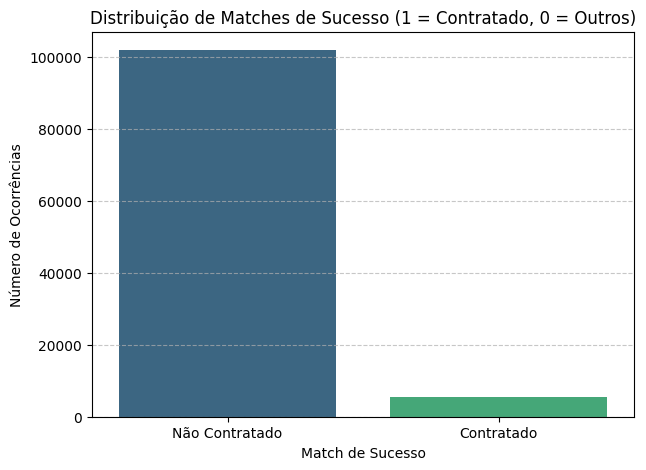

In [23]:
# --- 6. Definição da Variável Alvo: is_successful_match ---
# A variável alvo é derivada de 'situacao_candidado' do prospects.json.
# 'Contratado pela Decision' indica um match de sucesso, o que será nossa classe positiva (1).

print("\n--- 6. Análise da Variável Alvo: situacao_candidado ---")
print("Distribuição das diferentes situações de candidato:")
# Exibe a contagem de cada valor único na coluna 'situacao_candidado', incluindo valores NaN se houver.
print(final_df['situacao_candidado'].value_counts(dropna=False))

# Criar a variável binária 'is_successful_match'
# CORREÇÃO: Usar a string exata 'Contratado pela Decision' para identificar o match de sucesso.
final_df['is_successful_match'] = (final_df['situacao_candidado'] == 'Contratado pela Decision').astype(int)

print("\nDistribuição da variável binária 'is_successful_match':")
# Exibe a contagem de 0s e 1s na nova coluna 'is_successful_match'.
print(final_df['is_successful_match'].value_counts(dropna=False))

# Visualização da distribuição da variável alvo usando um gráfico de barras (countplot)
plt.figure(figsize=(7, 5)) # Define o tamanho da figura para o gráfico
# CORREÇÃO: Adicionado 'hue=is_successful_match' e 'legend=False' para resolver o FutureWarning e melhorar a visualização.
sns.countplot(x='is_successful_match', data=final_df, hue='is_successful_match', palette='viridis', legend=False) # Cria o countplot
plt.title('Distribuição de Matches de Sucesso (1 = Contratado, 0 = Outros)') # Título do gráfico
plt.xlabel('Match de Sucesso') # Rótulo do eixo X
plt.ylabel('Número de Ocorrências') # Rótulo do eixo Y
plt.xticks(ticks=[0, 1], labels=['Não Contratado', 'Contratado']) # Define os rótulos personalizados para os ticks do eixo X
plt.grid(axis='y', linestyle='--', alpha=0.7) # Adiciona um grid leve no eixo Y para melhor leitura
plt.show() # Exibe o gráfico

In [24]:
# --- 7. Análise de Dados Faltantes em final_df ---
print("\n--- 7. Análise de Dados Faltantes em final_df ---")

# Calcula a contagem de valores nulos para cada coluna no DataFrame final_df
missing_data = final_df.isnull().sum()

# Calcula a porcentagem de valores nulos para cada coluna
missing_percentage = (final_df.isnull().sum() / len(final_df)) * 100

# Cria um DataFrame para exibir a contagem e porcentagem de dados faltantes
missing_info = pd.DataFrame({'Missing Count': missing_data, 'Missing Percentage (%)': missing_percentage})

# Filtra para mostrar apenas as colunas que possuem dados faltantes (contagem > 0)
# E as ordena pela porcentagem de dados faltantes em ordem decrescente (do maior para o menor)
missing_info = missing_info[missing_info['Missing Count'] > 0].sort_values(by='Missing Percentage (%)', ascending=False)

# Exibe o DataFrame com as informações de dados faltantes
print(missing_info)


--- 7. Análise de Dados Faltantes em final_df ---
                                         Missing Count  Missing Percentage (%)
informacoes_basicas_nome_substituto             106288               98.878077
formacao_e_idiomas_outro_curso                  105742               98.370142
informacoes_profissionais_qualificacoes         105638               98.273392
cargo_atual_projeto_atual                       105638               98.273392
cargo_atual_email_corporativo                   105638               98.273392
...                                                ...                     ...
infos_basicas_sabendo_de_nos_por                 17328               16.119969
formacao_e_idiomas_nivel_espanhol                17328               16.119969
formacao_e_idiomas_outro_idioma                  17328               16.119969
formacao_e_idiomas_nivel_academico               17328               16.119969
formacao_e_idiomas_nivel_ingles                  17328               16.119969



In [25]:
# --- 8. Exploração de Colunas Chave para Feature Engineering ---

print("\n--- 8. Exploração de Colunas Chave e Conteúdo ---")

# Nível profissional de candidatos e vagas
print("\n--- Níveis Profissionais (Candidato) ---")
# Exibe a contagem de cada nível profissional do candidato, incluindo NaNs.
print(final_df['informacoes_profissionais_nivel_profissional'].value_counts(dropna=False))

print("\n--- Níveis Profissionais (Vaga) ---")
# Exibe a contagem de cada nível profissional da vaga, incluindo NaNs.
print(final_df['perfil_vaga_nivel profissional'].value_counts(dropna=False))

# Níveis de idiomas (Inglês, Espanhol) de candidatos e vagas
print("\n--- Níveis de Inglês (Candidato) ---")
# Exibe a contagem de cada nível de inglês do candidato, incluindo NaNs.
print(final_df['formacao_e_idiomas_nivel_ingles'].value_counts(dropna=False))

print("\n--- Níveis de Inglês (Vaga) ---")
# Exibe a contagem de cada nível de inglês da vaga, incluindo NaNs.
print(final_df['perfil_vaga_nivel_ingles'].value_counts(dropna=False))

print("\n--- Níveis de Espanhol (Candidato) ---")
# Exibe a contagem de cada nível de espanhol do candidato, incluindo NaNs.
print(final_df['formacao_e_idiomas_nivel_espanhol'].value_counts(dropna=False))

print("\n--- Níveis de Espanhol (Vaga) ---")
# Exibe a contagem de cada nível de espanhol da vaga, incluindo NaNs.
print(final_df['perfil_vaga_nivel_espanhol'].value_counts(dropna=False))

# Conhecimentos Técnicos (campo de texto do candidato)
print("\n--- Exemplo de Conhecimentos Técnicos (Candidato) - Amostra ---")
# Pega 5 amostras aleatórias de conhecimentos técnicos não nulos.
# random_state=42 garante que a amostra seja a mesma a cada execução para reprodutibilidade.
sample_tech_skills = final_df['informacoes_profissionais_conhecimentos_tecnicos'].dropna().sample(5, random_state=42).tolist()
for i, skill in enumerate(sample_tech_skills):
    # Imprime a amostra, limitando a 100 caracteres para não poluir a saída.
    print(f"{i+1}. {skill[:100]}..." if len(skill) > 100 else f"{i+1}. {skill}")

# Principais Atividades da Vaga (campo de texto da vaga)
print("\n--- Exemplo de Principais Atividades (Vaga) - Amostra ---")
# Pega 5 amostras aleatórias de principais atividades não nulas.
sample_activities = final_df['perfil_vaga_principais_atividades'].dropna().sample(5, random_state=42).tolist()
for i, activity in enumerate(sample_activities):
    # Imprime a amostra, limitando a 100 caracteres.
    print(f"{i+1}. {activity[:100]}..." if len(activity) > 100 else f"{i+1}. {activity}")

# Competências Técnicas e Comportamentais da Vaga (campo de texto da vaga)
print("\n--- Exemplo de Competências Técnicas e Comportamentais (Vaga) - Amostra ---")
# Pega 5 amostras aleatórias de competências não nulas.
sample_competencies = final_df['perfil_vaga_competencia_tecnicas_e_comportamentais'].dropna().sample(5, random_state=42).tolist()
for i, competency in enumerate(sample_competencies):
    # Imprime a amostra, limitando a 100 caracteres.
    print(f"{i+1}. {competency[:100]}..." if len(competency) > 100 else f"{i+1}. {competency}")

# CV Completo em Português (campo de texto do candidato)
print("\n--- Exemplo de CV (Português) - Amostra ---")
# Pega 1 amostra aleatória de CV em português não nula.
sample_cv = final_df['cv_pt'].dropna().sample(1, random_state=42).iloc[0]
# Imprime os primeiros 500 caracteres do CV ou o CV completo se for menor.
print(sample_cv[:500] + "..." if len(sample_cv) > 500 else sample_cv)

# Tipos de Contratação
print("\n--- Tipos de Contratação (Vaga) ---")
# Exibe a contagem de cada tipo de contratação, incluindo NaNs.
print(final_df['informacoes_basicas_tipo_contratacao'].value_counts(dropna=False))

# Áreas de Atuação (candidato e vaga)
print("\n--- Áreas de Atuação (Candidato) ---")
# Exibe a contagem de cada área de atuação do candidato, incluindo NaNs.
print(final_df['informacoes_profissionais_area_atuacao'].value_counts(dropna=False))

print("\n--- Áreas de Atuação (Vaga) ---")
# Exibe a contagem de cada área de atuação da vaga, incluindo NaNs.
print(final_df['perfil_vaga_areas_atuacao'].value_counts(dropna=False))

# Verificar se a vaga é SAP
print("\n--- Vaga SAP (Vaga) ---")
# Exibe a contagem para a coluna 'vaga_sap', incluindo NaNs.
print(final_df['informacoes_basicas_vaga_sap'].value_counts(dropna=False))



--- 8. Exploração de Colunas Chave e Conteúdo ---

--- Níveis Profissionais (Candidato) ---
informacoes_profissionais_nivel_profissional
                          89580
NaN                       17328
Sênior                      350
Especialista                 92
Pleno                        54
Analista                     32
Líder                        30
Júnior                       18
Técnico de Nível Médio        4
Gerente                       4
Estagiário                    2
Name: count, dtype: int64

--- Níveis Profissionais (Vaga) ---
perfil_vaga_nivel profissional
NaN                       54259
Analista                  20060
Sênior                    19546
Pleno                      8501
Júnior                     2450
Especialista               1326
Assistente                  647
Líder                       288
Gerente                     233
Coordenador                 113
Supervisor                   36
Auxiliar                     17
Aprendiz                      9


In [26]:
# --- 9. Primeiras Observações para Feature Engineering ---
print("\n--- 9. Primeiras Observações para Feature Engineering ---")
print("Baseado na Análise Exploratória de Dados (EDA) e na exploração das colunas chave, as seguintes observações e planos de feature engineering são propostos:")

print("\n**1. Variável Alvo (`is_successful_match`):**")
print("- Identificada e criada com sucesso. Observamos um desbalanceamento considerável (muitos mais casos 'Não Contratado' do que 'Contratado'), o que exigirá atenção no treinamento do modelo (ex: undersampling, oversampling, ajuste de pesos de classe ou foco em métricas como F1-Score/ROC AUC).")

print("\n**2. Dados Categóricos:**")
print("- Níveis Profissionais, Acadêmicos e de Idiomas (candidato e vaga): Ideais para features de 'match' direto ou de proximidade (ex: se o nível do candidato >= nível da vaga). Precisarão de codificação (Label Encoding para ordem, One-Hot Encoding para categorias nominais sem ordem clara).")
print("- Tipos de Contratação, Áreas de Atuação: Necessitam de One-Hot Encoding ou tratamento para alta cardinalidade.")
print("- Campos binários como 'vaga_sap' e 'vaga_especifica_para_pcd': Podem ser usados diretamente após conversão para 0/1, mas o 'vaga_especifica_para_pcd' tem muitos valores faltantes.")

print("\n**3. Dados Numéricos/Textuais para Extração Numérica:**")
print("- Remuneração (candidato) e Faixa Etária (vaga): Contêm valores inconsistentes ou textuais (ex: 'De: Até:'). Precisarão de extração de valores numéricos e tratamento de nulos.")
print("- Datas (data_criacao, data_requicisao, data_atualizacao): Podem ser usadas para calcular tempo desde a criação da vaga/candidato, tempo de processo (duração da prospecção), ou para extrair features sazonais (mês, ano).")

print("\n**4. Dados Textuais (NLP Clássico para Feature Engineering):**")
print("- `cv_pt` (candidato): Campo rico que descreve a experiência e habilidades. Fundamental para comparar com os requisitos da vaga.")
print("- `informacoes_profissionais_conhecimentos_tecnicos` (candidato): Lista de habilidades técnicas. Pode ser tokenizado e comparado com requisitos da vaga.")
print("- `perfil_vaga_principais_atividades` (vaga): Descrição das responsabilidades da vaga.")
print("- `perfil_vaga_competencia_tecnicas_e_comportamentais` (vaga): Habilidades e comportamentos desejados.")

print("\n**5. Estratégias para Features de Texto:**")
print("- **Pré-processamento de Texto:** Limpeza (minúsculas, remoção de pontuação, números, URLs, stopwords), lematização/stemming (se o tempo permitir, caso contrário, apenas limpeza básica).")
print("- **Vetorização:** Utilizar TF-IDF (Term Frequency-Inverse Document Frequency) para converter os textos em representações numéricas.")
print("- **Features de Similaridade:** Calcular a similaridade de cosseno entre o vetor TF-IDF do CV do candidato (ou conhecimentos técnicos) e os vetores TF-IDF dos requisitos da vaga (atividades, competências). Essa métrica de similaridade será uma feature poderosa para o modelo.")

print("\n**6. Tratamento de Dados Faltantes:**")
print("- Muitas colunas apresentam valores faltantes, com porcentagens que variam de 16% a quase 99%. Será necessário definir estratégias de imputação robustas:")
print("  - **Colunas com >90% de NaNs (e.g., `informacoes_basicas_nome_substituto`, `cargo_atual_`):** Avaliar a exclusão, pois podem não agregar valor. A ausência da informação pode ser uma feature por si só em alguns casos.")
print("  - **Colunas com 15-80% de NaNs (e.g., `perfil_vaga_nivel profissional`, `informacoes_profissionais_remuneracao`):** Estratégias como preenchimento com 'Não Informado' (para categóricas), moda, mediana (para numéricas) ou a criação de um indicador binário 'is_missing' podem ser aplicadas.")
print("  - **Campos de localização (país, estado, cidade, bairro, região):** Podem ser combinados para criar features de match geográfico. Lidar com NaNs e valores inconsistentes.")

print("\n**Próximo Passo:** Com base nestas observações, o próximo passo será implementar as funções de Pré-processamento e Feature Engineering em um script Python dedicado (`src/data_processing.py`). Este script será modular e reutilizável na pipeline de treinamento e na API.")

print("\n--- EDA Concluída com Primeiras Observações para Feature Engineering ---")



--- 9. Primeiras Observações para Feature Engineering ---
Baseado na Análise Exploratória de Dados (EDA) e na exploração das colunas chave, as seguintes observações e planos de feature engineering são propostos:

**1. Variável Alvo (`is_successful_match`):**
- Identificada e criada com sucesso. Observamos um desbalanceamento considerável (muitos mais casos 'Não Contratado' do que 'Contratado'), o que exigirá atenção no treinamento do modelo (ex: undersampling, oversampling, ajuste de pesos de classe ou foco em métricas como F1-Score/ROC AUC).

**2. Dados Categóricos:**
- Níveis Profissionais, Acadêmicos e de Idiomas (candidato e vaga): Ideais para features de 'match' direto ou de proximidade (ex: se o nível do candidato >= nível da vaga). Precisarão de codificação (Label Encoding para ordem, One-Hot Encoding para categorias nominais sem ordem clara).
- Tipos de Contratação, Áreas de Atuação: Necessitam de One-Hot Encoding ou tratamento para alta cardinalidade.
- Campos binários como '